In [392]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch import nn
from torch import optim
import numpy as np
import matplotlib.pyplot as plt

In [244]:
# Use GPU if applicable
print(torch.cuda.is_available())
device = "cpu"
if torch.cuda.is_available():
    device = "cuda"
device

True


'cuda'

In [379]:
# Download Caltech101 Data, Only need to run this cell once
dataset = datasets.Caltech101(
    root="dataset",
    download=True
)

Files already downloaded and verified


In [380]:
# Make size consistant
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.GaussianBlur(5, 1),
    transforms.ToTensor(),
])
dataset.transform = transform

In [381]:
# Make number of channels consistant (some pics are B&W so we will convert them to 3 channels by duplicating the single channel)
num = 0
new_dataset = []
for i in range(len(dataset)):
    if dataset[i][0].shape != torch.Size([3, 256, 256]):
        new_dataset.append((dataset[i][0].repeat(3,1,1) , dataset[i][1]))
    else:
        new_dataset.append((dataset[i][0] , dataset[i][1]))

In [382]:
# Use a 80/20 split for train/test
train_len = int(len(new_dataset) * .8)
train, test = torch.utils.data.random_split(new_dataset, [train_len, len(new_dataset) - train_len])
print(len(train))
print(len(test))

6941
1736


In [537]:
# Relatively light NN with no pretrained elements
class simpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, (7,7), 2),
            nn.MaxPool2d(3, 3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 196, (5,5), 2),
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(196),
            nn.ReLU(),
            nn.Conv2d(196, 256, (3,3), 2)
        )
        self.flatten = nn.Flatten()
        self.fclayer = nn.Sequential(
            nn.Linear(256 * 4 * 4, 256*4),
            nn.ReLU(),
            nn.Dropout(p=.5),
            nn.Linear(256 * 4, 101)
        )
    def forward(self, x):
        x = self.cnn(x)
        x = self.flatten(x)
        x = self.fclayer(x)
        return x

In [538]:
# Print model
model = simpleNet().to(device)
model

simpleNet(
  (cnn): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Conv2d(64, 196, kernel_size=(5, 5), stride=(2, 2))
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): BatchNorm2d(196, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): ReLU()
    (8): Conv2d(196, 256, kernel_size=(3, 3), stride=(2, 2))
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fclayer): Sequential(
    (0): Linear(in_features=4096, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.5, inplace=False)
    (3): Linear(in_features=1024, out_features=101, bias=True)
  )
)

In [539]:
# Hyper Params
batch_size = 64
loss_func = nn.CrossEntropyLoss()
lr = .0001
weight_decay = .008
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
epochs = 30
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=epochs/3, gamma=0.3)


In [540]:
train_dataloader = torch.utils.data.DataLoader(train, batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(test, batch_size=batch_size)

In [541]:
train_losses = []
test_losses = []
train_accuracy = []
test_accuracy = []
for i in range(epochs):
    # variables needed for metrics later
    train_size = len(train_dataloader.dataset)
    model.train()
    train_loss = 0
    train_correct = 0
    train_num_batches = len(train_dataloader)
    for batch, (X, labels) in enumerate(train_dataloader):
        X = X.to(device)
        labels = labels.to(device)

        # Model pred + loss
        pred = model(X)
        loss = loss_func(pred, labels)

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Compute metrics
        train_loss+=loss.item()
        train_correct+=(pred.argmax(axis = 1) == labels).type(torch.float).sum().item()
    train_losses.append(train_loss/train_num_batches)
    train_accuracy.append(train_correct/train_size)
    


    test_size = len(test_dataloader.dataset)
    test_num_batches = len(test_dataloader)
    model.eval()
    test_loss = 0
    test_correct = 0
    with torch.no_grad():
        for X, labels in test_dataloader:
            X = X.to(device)
            labels = labels.to(device)

            # Model pred + loss
            pred = model(X)
            loss = loss_func(pred, labels)

            # Compute metrics
            test_loss+=loss.item()
            test_correct+=(pred.argmax(axis = 1) == labels).type(torch.float).sum().item()
        test_losses.append(test_loss/test_num_batches)
        test_accuracy.append(test_correct/test_size)
    scheduler.step()
    if i % 1 == 0: #Change if it is generating too many lines
        print(f"Epoch: {i} Train_Avg_Loss: {(train_losses[-1]):2.8f} Train Accuracy: {(train_accuracy[-1]*100):3.2f}%")
        print(f"Epoch: {i} Test_Avg_Loss: {(test_losses[-1]):2.8f} Test Accuracy: {(test_accuracy[-1]*100):3.2f}%")

Epoch: 0 Train_Avg_Loss: 3.38117280 Train Accuracy: 29.62%
Epoch: 0 Test_Avg_Loss: 2.69020818 Test Accuracy: 41.65%
Epoch: 1 Train_Avg_Loss: 2.34918172 Train Accuracy: 48.00%
Epoch: 1 Test_Avg_Loss: 2.04065637 Test Accuracy: 53.97%
Epoch: 2 Train_Avg_Loss: 1.79045512 Train Accuracy: 58.33%
Epoch: 2 Test_Avg_Loss: 1.73828100 Test Accuracy: 60.77%
Epoch: 3 Train_Avg_Loss: 1.42816292 Train Accuracy: 65.84%
Epoch: 3 Test_Avg_Loss: 1.52687534 Test Accuracy: 64.23%
Epoch: 4 Train_Avg_Loss: 1.17957105 Train Accuracy: 71.10%
Epoch: 4 Test_Avg_Loss: 1.43556423 Test Accuracy: 66.42%
Epoch: 5 Train_Avg_Loss: 0.99733618 Train Accuracy: 75.41%
Epoch: 5 Test_Avg_Loss: 1.33987961 Test Accuracy: 69.12%
Epoch: 6 Train_Avg_Loss: 0.85202560 Train Accuracy: 79.15%
Epoch: 6 Test_Avg_Loss: 1.31520597 Test Accuracy: 69.41%
Epoch: 7 Train_Avg_Loss: 0.72716044 Train Accuracy: 82.06%
Epoch: 7 Test_Avg_Loss: 1.31315564 Test Accuracy: 69.12%
Epoch: 8 Train_Avg_Loss: 0.64357382 Train Accuracy: 84.11%
Epoch: 8 Test

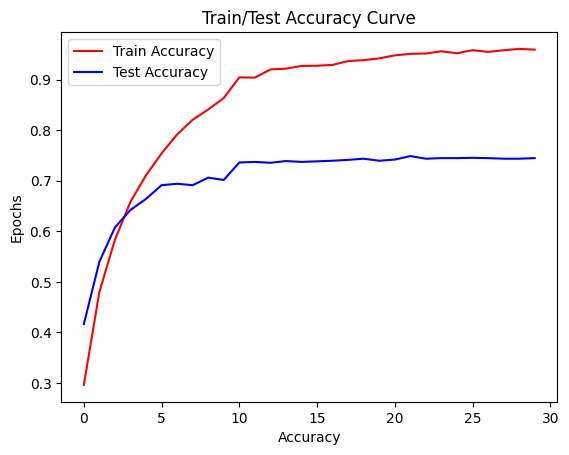

In [542]:
# Graphs! (Accuracy)
x = np.arange(0, epochs)
 
plt.title("Train/Test Accuracy Curve")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.plot(x, train_accuracy, color ="red", label = "Train Accuracy")
plt.plot(x, test_accuracy, color ="blue", label = "Test Accuracy")
plt.legend()
plt.show()

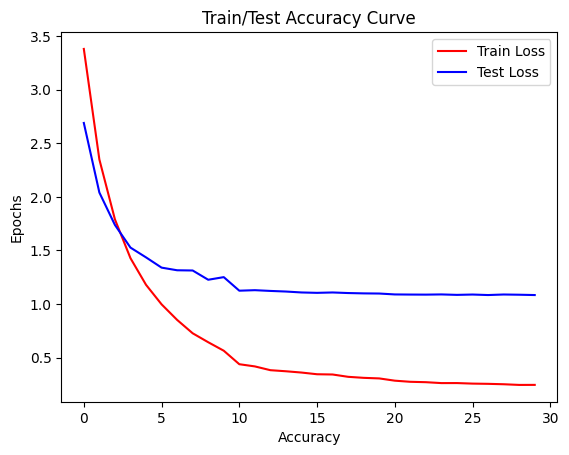

In [543]:
# Graphs! (Loss)
x = np.arange(0, epochs)
 
plt.title("Train/Test Accuracy Curve")
plt.xlabel("Accuracy")
plt.ylabel("Epochs")
plt.plot(x, train_losses, color ="red", label = "Train Loss")
plt.plot(x, test_losses, color ="blue", label = "Test Loss")
plt.legend()
plt.show()